In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import (train_test_split, 
                                     cross_val_score, 
                                     cross_validate, 
                                     StratifiedKFold,
                                     GridSearchCV,
                                     RepeatedStratifiedKFold)
from sklearn.metrics import (accuracy_score, 
                             roc_auc_score,
                             classification_report, 
                             precision_score, 
                             recall_score, 
                             confusion_matrix, 
                             precision_recall_curve, 
                             roc_curve, 
                             auc, 
                             log_loss)

from sklearn.feature_selection import RFE, RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:

current_path = os.getcwd()
print("The current working directory is:", current_path)
 

The current working directory is: /Users/anhdang/Documents/Github/COS30082-AppliedML/lab03/Titanic Survival Prediction


In [3]:
# Load the dataset
dataset = pd.read_csv('Titanic-Dataset.csv')

In [4]:
dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
dataset.shape

(891, 12)

In [6]:
dataset.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
dataset.columns.values

array(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'], dtype=object)

In [8]:
total = dataset.isnull().sum().sort_values(ascending=False)
total

Cabin          687
Age            177
Embarked         2
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Fare             0
dtype: int64

# Age

In [9]:
print('Percent of missing "Age" records is %.2f%%' %((dataset['Age'].isnull().sum()/dataset.shape[0])*100))

Percent of missing "Age" records is 19.87%


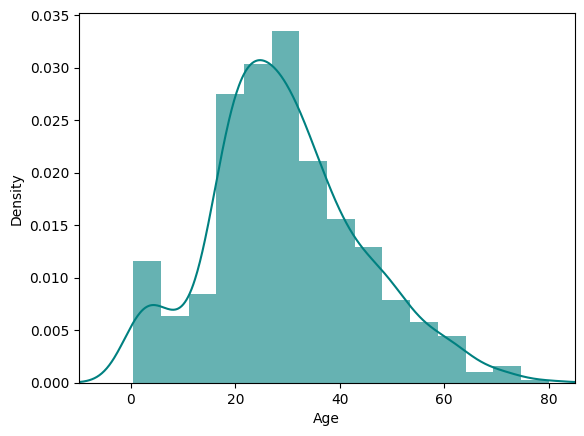

In [10]:
ax = dataset["Age"].hist(bins=15, density=True, stacked=True, color='teal', alpha=0.6)
dataset["Age"].plot(kind='density', color='teal')
ax.set(xlabel='Age')
plt.xlim(-10,85)
plt.show()

In [11]:
# mean age
print('The mean of "Age" is %.2f' %(dataset["Age"].mean(skipna=True)))
# median age
print('The median of "Age" is %.2f' %(dataset["Age"].median(skipna=True)))

The mean of "Age" is 29.70
The median of "Age" is 28.00


# Cabin

In [12]:
print('Percent of missing "Cabin" records is %.2f%%' %((dataset['Cabin'].isnull().sum()/dataset.shape[0])*100))

Percent of missing "Cabin" records is 77.10%


# Embarked

In [13]:
print('Percent of missing "Embarked" records is %.2f%%' %((dataset['Embarked'].isnull().sum()/dataset.shape[0])*100))

Percent of missing "Embarked" records is 0.22%


Boarded passengers grouped by port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton):
Embarked
S    644
C    168
Q     77
Name: count, dtype: int64


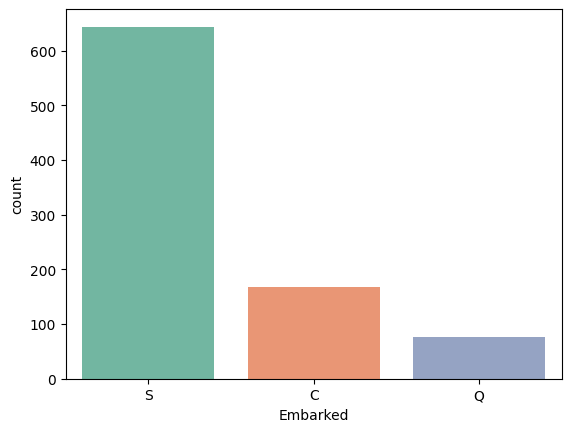

In [14]:
print('Boarded passengers grouped by port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton):')
print(dataset['Embarked'].value_counts())
sns.countplot(x='Embarked', data=dataset, palette='Set2')
plt.show()

In [15]:
print('The most common boarding port of embarkation is %s.' %dataset['Embarked'].value_counts().idxmax())

The most common boarding port of embarkation is S.


# Data Preprocessing

In [16]:
def preprocessing(dataset):
    
    # Convert 'Sex' to numerical
    label_encoder = LabelEncoder()
    dataset['Sex'] = label_encoder.fit_transform(dataset['Sex'])
    
    # Fill missing values
    dataset["Age"].fillna(dataset["Age"].median(skipna=True), inplace=True)
    dataset["Embarked"].fillna(dataset['Embarked'].value_counts().idxmax(), inplace=True)
    
    # Adding new column to check if passenger is a child
    dataset['IsChild'] = np.where(dataset['Age']<=16, 1, 0)
    
    print(dataset.isnull().sum())
    
    ## Create categorical variable for traveling alone
    dataset['TravelAlone']=np.where((dataset["SibSp"]+dataset["Parch"])>0, 0, 1)
    dataset.drop('SibSp', axis=1, inplace=True)
    dataset.drop('Parch', axis=1, inplace=True)
    
    # Create categorical variables and drop some variables
    dataset=pd.get_dummies(dataset, columns=["Pclass","Embarked"])
    
    # Convert True/False values to 0/1 for Embarked
    dataset['Embarked_C'] = dataset['Embarked_C'].astype(int)
    dataset['Embarked_Q'] = dataset['Embarked_Q'].astype(int)
    dataset['Embarked_S'] = dataset['Embarked_S'].astype(int)
    
    # Convert True/False values to 0/1 for Pclass
    dataset['Pclass_1'] = dataset['Pclass_1'].astype(int)
    dataset['Pclass_2'] = dataset['Pclass_2'].astype(int)
    dataset['Pclass_3'] = dataset['Pclass_3'].astype(int)

    # Drop the columns
    dataset.drop(['Cabin','PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
    
    print(dataset.head(5))  
    return dataset


In [17]:
raw_dataset = dataset.copy()
clean_dataset = preprocessing(raw_dataset)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
IsChild          0
dtype: int64
   Survived  Sex   Age     Fare  IsChild  TravelAlone  Pclass_1  Pclass_2  \
0         0    1  22.0   7.2500        0            0         0         0   
1         1    0  38.0  71.2833        0            0         1         0   
2         1    0  26.0   7.9250        0            1         0         0   
3         1    0  35.0  53.1000        0            0         1         0   
4         0    1  35.0   8.0500        0            1         0         0   

   Pclass_3  Embarked_C  Embarked_Q  Embarked_S  
0         1           0           0           1  
1         0           1           0           0  
2         1           0           0           1  
3         0           0           0           1  
4         1           0    

# Logistic Regression Trainer

In [18]:
class LogisticRegressionTrainer:
    """
    A class for training a Logistic Regression model with automated feature selection and hyperparameter tuning.
    """

    def __init__(self, dataset, target_column='Survived', test_size=0.2, random_state=42, max_iter=1000, cv_splits=5):
        """
        Initializes the trainer with the dataset and training parameters.
        """
        
        self.dataset = dataset
        self.target_column = target_column
        self.test_size = test_size
        self.random_state = random_state
        self.max_iter = max_iter
        self.cv_splits = cv_splits
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.selected_features = []
        self.grid_search = None

    def _find_best_features(self):
        """
        Identifies the best features for the Logistic Regression model using Recursive Feature Elimination.
        """
        
        columns = self.dataset.columns.tolist()
        predictors = [column for column in columns if column != self.target_column]

        X = self.dataset[predictors].values
        y = self.dataset[self.target_column].values.ravel()

        model = LogisticRegression(max_iter=self.max_iter, solver='liblinear')
        rfecv = RFECV(estimator=model, step=1, cv=StratifiedKFold(5), scoring='accuracy')
        rfecv.fit(X, y)

        print(f"Optimal number of features: {rfecv.n_features_}")
        self.selected_features = [predictors[i] for i in range(len(predictors)) if rfecv.support_[i]]
        print(f'Selected features: {self.selected_features}')

        self._split_dataset()

    def _split_dataset(self):
        """
        Splits the dataset into training and testing sets based on the selected features.
        """
        X_selected = self.dataset[self.selected_features]
        y = self.dataset[self.target_column].values.ravel()

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X_selected, y, test_size=self.test_size, random_state=self.random_state
        )

    def _train_logistic_regression_model(self):
        """
        Trains the Logistic Regression model using GridSearchCV for hyperparameter tuning.
        """
        
        pipeline = Pipeline([
            ('logreg', LogisticRegression(solver='liblinear', max_iter=self.max_iter, random_state=self.random_state))
        ])

        param_grid = {
            'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100],
            'logreg__penalty': ['l1', 'l2']
        }

        cv_strategy = StratifiedKFold(n_splits=self.cv_splits, shuffle=True, random_state=self.random_state)
        self.grid_search = GridSearchCV(pipeline, param_grid, cv=cv_strategy, scoring='accuracy', verbose=1)
        self.grid_search.fit(self.X_train, self.y_train)

        print(f"Best parameters: {self.grid_search.best_params_}")

    def _evaluate_model(self):
        """
        Evaluates the model's performance on the test set and prints metrics.
        """
        
        y_pred = self.grid_search.predict(self.X_test)
        y_pred_proba = self.grid_search.predict_proba(self.X_test)[:, 1]

        accuracy = accuracy_score(self.y_test, y_pred)
        recall = recall_score(self.y_test, y_pred)
        roc_auc = roc_auc_score(self.y_test, y_pred_proba)

        print(f"Accuracy on test set: {accuracy:.2f}")
        print(f"Recall: {recall:.2f}")
        print(f"ROC AUC score on test set: {roc_auc:.2f}")
        print("\nClassification Report:\n", classification_report(self.y_test, y_pred))

    def train(self):
        """
        Public method to train the model and evaluate its performance.
        """
        
        if not self.X_train or not self.y_train:
            print("Dataset not prepared for training. Finding best features first.")
            self._find_best_features()
        self._train_logistic_regression_model()
    
    def evaluate(self):
        self._evaluate_model()
        
    def predict(self, X_new):
        """
        Makes predictions on new data using the trained model.
        """
        
        if self.grid_search is None:
            print("Model is not trained yet. Please train the model before making predictions.")
            return None
        
        if self.selected_features:
            X_new_selected = X_new[self.selected_features]
        else:
            print("Selected features are not identified. Please check the model training process.")
            return None
        
        predictions = self.grid_search.predict(X_new_selected)
        return predictions

In [19]:
model = LogisticRegressionTrainer(clean_dataset, 
                                    target_column='Survived', 
                                    test_size=0.5, 
                                    random_state=42, 
                                    max_iter=500, 
                                    cv_splits=5)
model.train()
model.evaluate()

Dataset not prepared for training. Finding best features first.
Optimal number of features: 11
Selected features: ['Sex', 'Age', 'Fare', 'IsChild', 'TravelAlone', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S']
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'logreg__C': 10, 'logreg__penalty': 'l1'}
Accuracy on test set: 0.79
Recall: 0.69
ROC AUC score on test set: 0.85

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.86      0.83       267
           1       0.77      0.69      0.73       179

    accuracy                           0.79       446
   macro avg       0.79      0.78      0.78       446
weighted avg       0.79      0.79      0.79       446



# Dummy Data Frame

In [20]:
dummy_data = {
    'PassengerId': [1000, 1001, 1002],
    'Pclass': [1, 3, 2],
    'Name': ['John Doe', 'Jane Doe', 'Alex Doe'],
    'Sex': ['male', 'female', 'female'],
    'Age': [22, 38, np.nan],
    'SibSp': [1, 1, 0],
    'Parch': [0, 2, 0],
    'Ticket': ['A/5 21171', 'PC 17599', 'STON/O2. 3101282'],
    'Fare': [7.25, 71.2833, 15.0458],
    'Cabin': [np.nan, 'C85', np.nan],
    'Embarked': ['S', 'C', 'Q']
}

dummy_df = pd.DataFrame(dummy_data)

processed_dummy_df = preprocessing(dummy_df)

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          2
Embarked       0
IsChild        0
dtype: int64
   Sex   Age     Fare  IsChild  TravelAlone  Pclass_1  Pclass_2  Pclass_3  \
0    1  22.0   7.2500        0            0         1         0         0   
1    0  38.0  71.2833        0            0         0         0         1   
2    0  30.0  15.0458        0            1         0         1         0   

   Embarked_C  Embarked_Q  Embarked_S  
0           0           0           1  
1           1           0           0  
2           0           1           0  


In [21]:
# Displaying predictions in a readable format
dummy_prediction = model.predict(processed_dummy_df)

for i, pred in enumerate(dummy_prediction):
    print(f"Person {i+1} prediction: {'Survived' if pred == 1 else 'Not survived'}")

Person 1 prediction: Not survived
Person 2 prediction: Survived
Person 3 prediction: Survived
